Authors: David Zhen Yin (yinzhen@stanford.edu)

Dec, 2023

Ref: 
Yin, Z., Miltenberger., A., Topinka, M., Wang., L., & Caers., J. (2023) Quantifying model misrepresentation in geophysical inversion for critical mineral explorations. [Download: https://drive.google.com/file/d/1Z8D9RuiAz-GuL2uhCC6z_eIVMPanXhEv/view?usp=drive_link]

Slides #5 & #6: https://docs.google.com/presentation/d/1it3-iIQt7W3u0K3K0vIpnVY09hqmLVOy/edit?usp=drive_link&ouid=100668576389228730924&rtpof=true&sd=true

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.covariance import MinCovDet
from scipy.stats import multivariate_normal, gamma, lognorm, norm, uniform
import scipy.stats as stats

from src.ANN import *
from src.PCA import *
from src.syn_funcs import * 
from src.MPPCA_density_estimate_David import *
from src.MPPCA_Mq_CrossValidation import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize']=18
plt.rcParams['xtick.labelsize']=17
plt.rcParams['ytick.labelsize']=17
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['figure.dpi'] = 72

2024-01-07 17:56:03.451080: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Ground truth dense body & gravity survey

## Truth

In [2]:
m_obs1 = [110, 80, 2610]
m_obs2 = [90, 55, 2710]
x1 = -15
x2 = 70
x = np.arange(-200,201, 20)

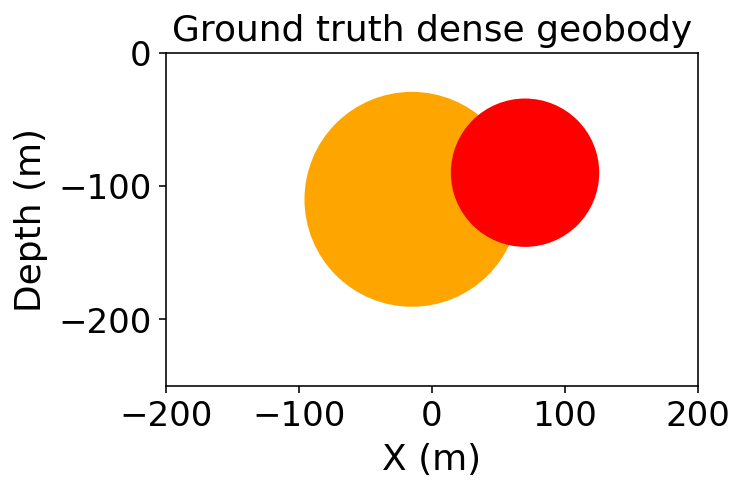

In [3]:
figure, axes = plt.subplots(figsize=(5.5,3))

Drawing_colored_circle1 = plt.Circle((x1, -m_obs1[0] ), m_obs1[1], color='orange')
axes.add_artist( Drawing_colored_circle1 )

Drawing_colored_circle2 = plt.Circle((x2 , -m_obs2[0] ),  m_obs2[1], color='red')
axes.add_artist( Drawing_colored_circle2 )

axes.set_aspect( 1 )
plt.ylim(0,-250), plt.xlim(-200,200)
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)'), plt.xlabel('X (m)')
plt.title( 'Ground truth dense geobody' )
plt.show()

## Observed gravity survey (d_obs) with measurment errors

Create the observed gravity survey without noise

In [4]:
dobs1 = g_z_mGal(m_obs1[0], m_obs1[1], m_obs1[2], x, c=x1).reshape(1,-1)
dobs2 = g_z_mGal(m_obs2[0], m_obs2[1], m_obs2[2], x, c=x2).reshape(1,-1)
dobs = dobs1+dobs2
dobs[0,0]=dobs[0,0]+0.04
dobs[0,1]=dobs[0,1]+0.03
dobs[0,2]=dobs[0,2]+0.03

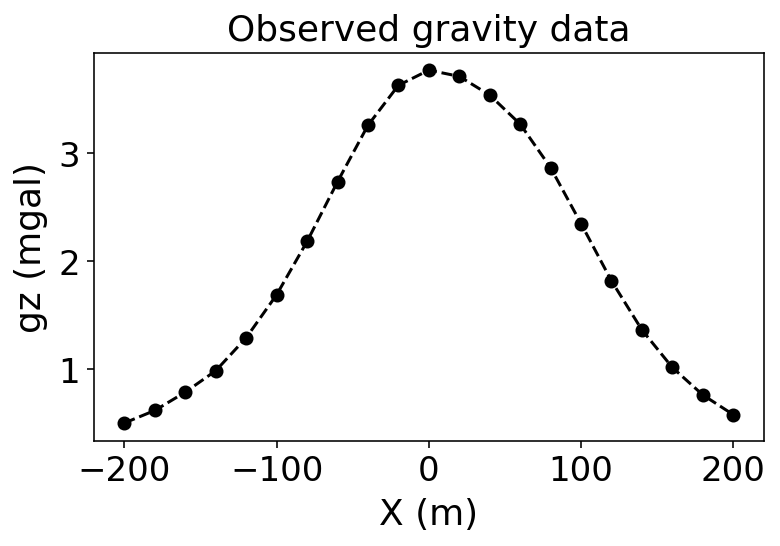

In [5]:
plt.figure(figsize=(6,3.5))
plt.plot(x, dobs[0], '.--', markersize=12, color='k')
plt.ylabel('gz (mgal)'), plt.xlabel('X (m)')
plt.title('Observed gravity data')
plt.show()

Add 5% observation error to the pure signal 

In [6]:
noise_lvl = 0.05 # 5% noise; 5% of dobs as noise std
sigma =(noise_lvl*dobs)**2 
error_sigma = np.identity(len(x))*sigma
error_mu = np.repeat(0, len(x))

n_Samples = 2000  # generate 2000 noisy samples
np.random.seed(0)
noise = np.random.multivariate_normal(error_mu,error_sigma,n_Samples)
print('noise level =', 100*noise_lvl, '%')

noise level = 5.0 %


Plot the observed data with observation noise

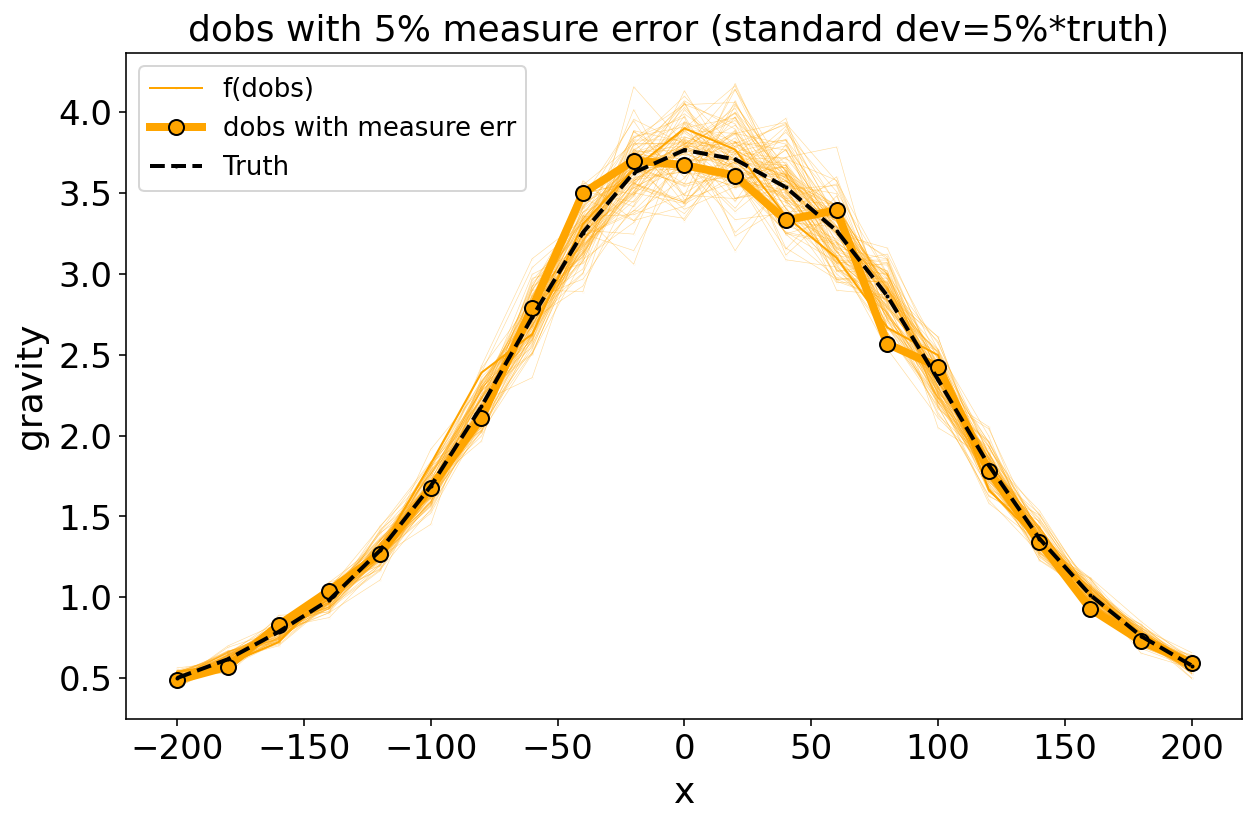

In [7]:
dobs_nsy = np.repeat(dobs, n_Samples, axis=0)  + noise
dobs_realnum = 11
dobs_nsy_survey = dobs_nsy[dobs_realnum:dobs_realnum+1]
plt.figure(figsize=(10,6))
for i in range(100):
    plt.plot(x, dobs_nsy[i], '.-', c='orange', markersize=0.1, linewidth=0.3, alpha=0.4)
plt.plot(x, dobs_nsy[i], '.-', c='orange', markersize=0.1, linewidth=1, label='f(dobs)')
plt.plot(x, dobs_nsy_survey[0], '.-', c='orange', 
         markersize=15,  markeredgecolor='k', 
         label='dobs with measure err', 
         linewidth=4)
plt.plot(x, dobs[0], '.--', label='Truth', color='k', linewidth=2, markersize=2)
plt.xlabel('x'),plt.ylabel('gravity')
plt.title('dobs with 5% measure error (standard dev=5%*truth) ')
plt.legend(prop={'size':13})
plt.show()

# Sequential Monte Carlo (SMC)

## Prior modeling

### Define a wide prior uncertainty of a single sphere

Define the minimum and maximum bound of the uniform distribution

In [8]:
# minimum and maximum bound of the uniform dist
prior_min = np.array([10.0,10,500.0]) # z, a, rho
prior_max = np.array([200.0,200,7000.0])

Monte Carlo sampling of prior

In [9]:
# Monte Carlo samples
n_Samples = 2000

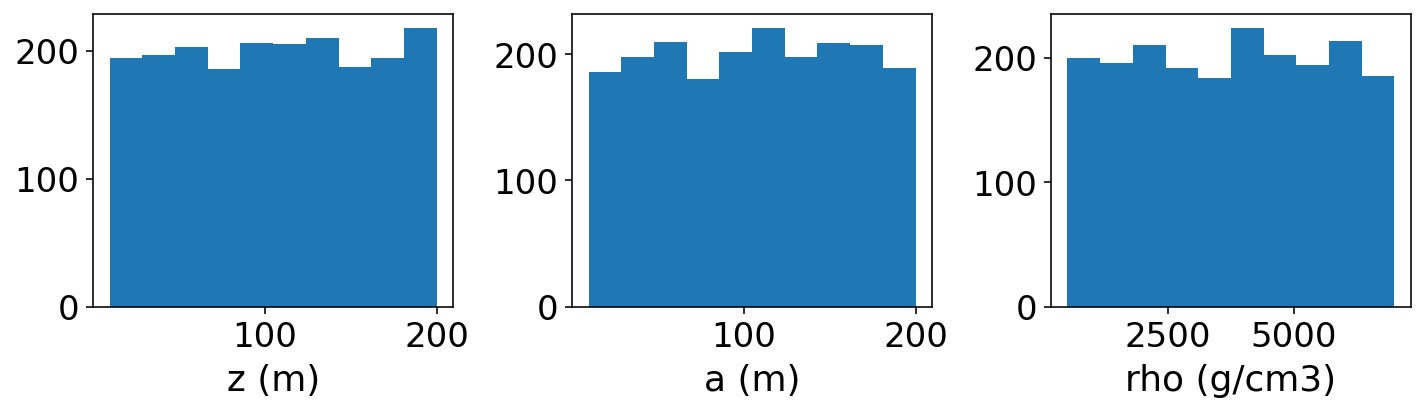

In [10]:
np.random.seed(1)
z_a_rho = np.random.uniform(prior_min, prior_max, (n_Samples,3))
par_names = ['z (m)', 'a (m)', 'rho (g/cm3)']
par_names_logrho = ['z', 'a', 'log(rho)']
prior_theta = pd.DataFrame(data=z_a_rho, columns=par_names)
plt.figure(figsize=(10,3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(z_a_rho[:,i])
    plt.xlabel(par_names[i])
plt.tight_layout()

Visualize the prior dense model vs the ground truth

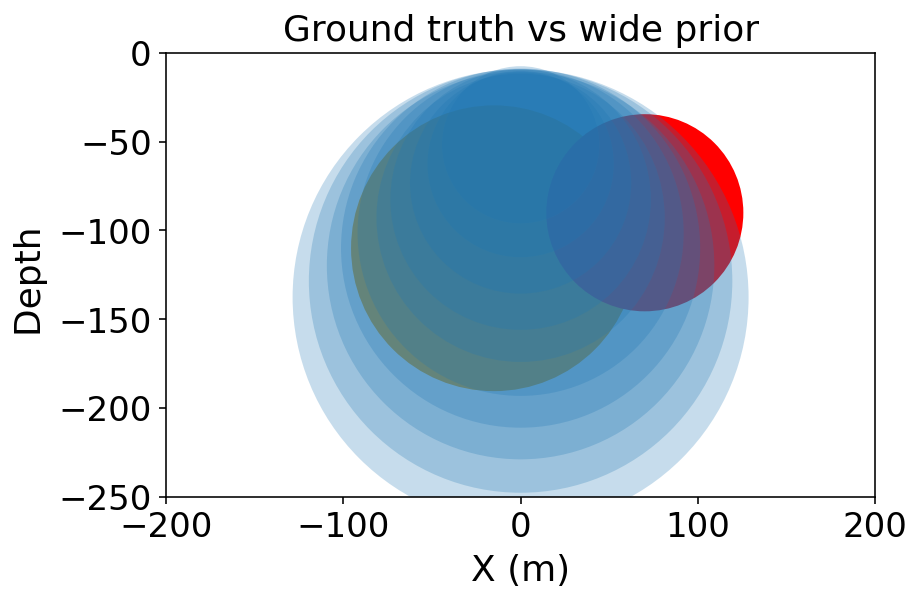

In [11]:
figure, axes = plt.subplots(figsize=(8,4))
pltquantiles = np.arange(0.25,0.75,0.05)
Drawing_colored_circle1 = plt.Circle((x1, -m_obs1[0] ), m_obs1[1], color='orange',
                                    label='C1')
axes.add_artist( Drawing_colored_circle1 )

Drawing_colored_circle2 = plt.Circle((x2 , -m_obs2[0] ),  m_obs2[1], color='red',
                                    label='C2')
axes.add_artist( Drawing_colored_circle2 )
for i in pltquantiles:
    Drawing_colored_circle = plt.Circle((0, -np.quantile(prior_theta['z (m)'].values,i)+5), 
                                    np.quantile(prior_theta['a (m)'].values,i)-15, 
                                     alpha=0.25
                                   )
    axes.add_artist( Drawing_colored_circle )
axes.set_aspect( 1 )
plt.ylim(0,-250), plt.xlim(-200,200)
plt.gca().invert_yaxis()
# plt.legend()
plt.ylabel('Depth '), plt.xlabel('X (m)')
plt.title( 'Ground truth vs wide prior' )
plt.show()

### Gravity data forward model using prior d = f(m)

Run forward model on the Monte Carlo Samples

In [12]:
gravity_data = []
for i in range(len(z_a_rho)):
    gravity_data.append(g_z_mGal(z_a_rho[i, 0], z_a_rho[i, 1], z_a_rho[i, 2], x))
gravity_data = np.asarray(gravity_data)

Plot the Monte Carlo data samples

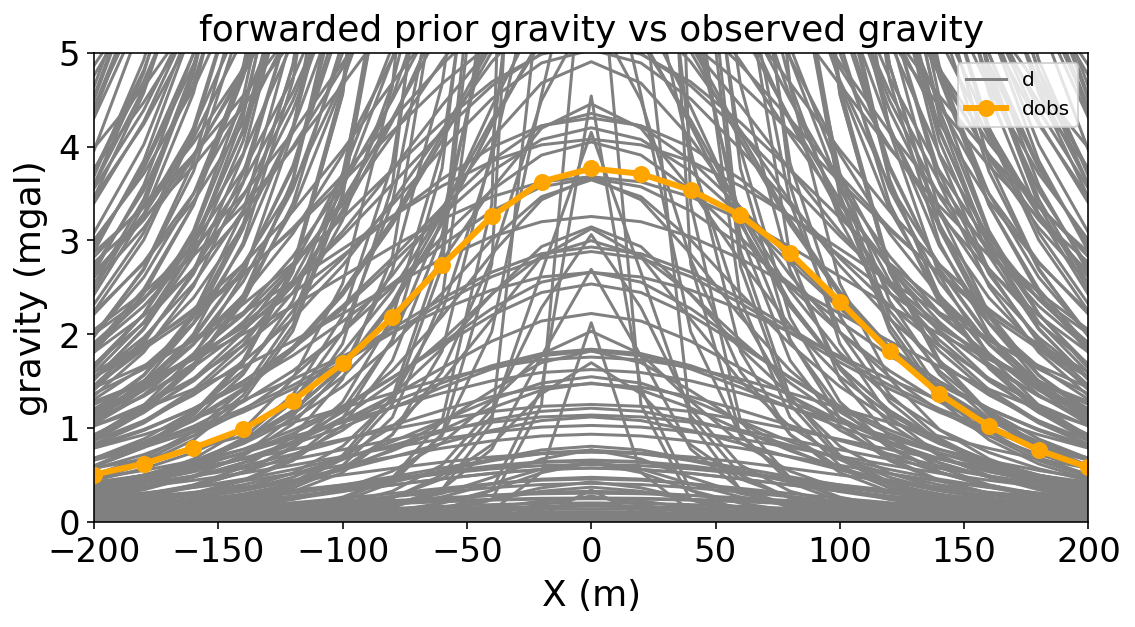

In [17]:
plt.figure(figsize=(8,4.5))

for i in range(250):
    plt.plot(x, gravity_data[i], '-',  color='grey')
plt.plot(x, gravity_data[0], '-', label='d', color='grey')
plt.plot(x, dobs[0], '.-', label='dobs', color='orange', linewidth=3, markersize=15)
plt.title('forwarded prior gravity vs observed gravity')
plt.legend(loc='upper right')
plt.ylim(0,5)
plt.xlabel('X (m)'), plt.ylabel('gravity (mgal)')
plt.xlim(-200, 200)
plt.tight_layout()

### Prior falsification using data

See explaination details in https://gmd.copernicus.org/articles/13/651/2020/, Section 2.1.3.

#### pca and falsification

Perform PCA to reduce the data dimension. 

In [16]:
retain_var = 99 # % Retain 95% of the data variance when performing PCA

In [17]:
d = gravity_data # assign gravity data as variable d 
d_pca = PCA(svd_solver='full').fit(d)
# determine to keep how many PCs
keepPCs = np.argmin(abs(d_pca.explained_variance_ratio_.cumsum() - retain_var/100)) +1
# PC scores of d
d_pcscr = d_pca.transform(d)[:,:keepPCs]
# PC scores of dobs
dobs_pcscr = d_pca.transform(dobs_nsy_survey)[:,:keepPCs]

Perform falsification using Robust Mahalanobis distance. 

See example in https://gmd.copernicus.org/articles/13/651/2020/, Section 3.3

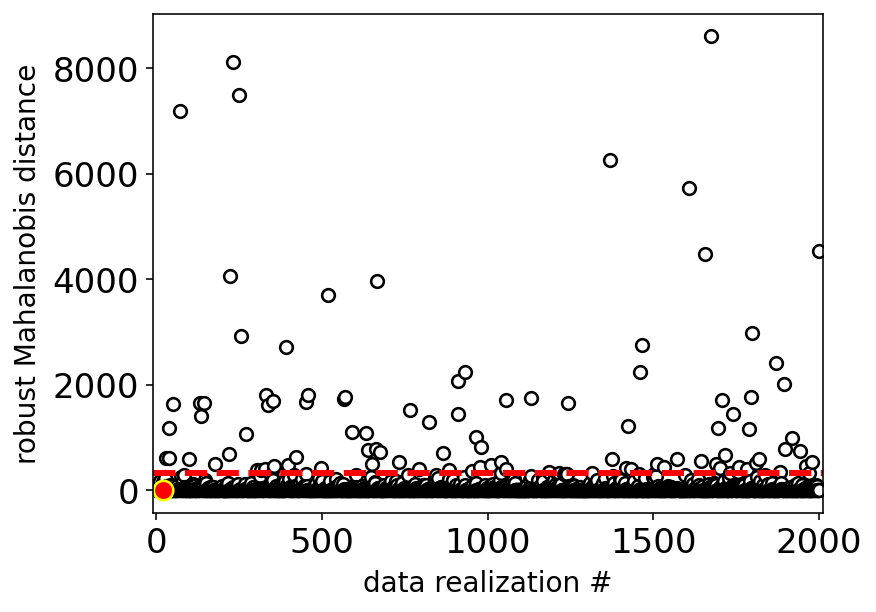

In [18]:
rob_cov = MinCovDet().fit(d_pcscr)
d_maha = np.sqrt(rob_cov.mahalanobis(d_pcscr))
dobs_maha = np.sqrt(rob_cov.mahalanobis(dobs_pcscr))
threshold = np.quantile(d_maha,0.95)

plt.figure(figsize=(6, 4.5))
plt.scatter(np.arange(1,(len(d_maha)+1)), d_maha,  \
            s=40,  \
            linewidths=1.3, edgecolor='k', c='w')
plt.scatter(20, dobs_maha,  \
            s=95,  \
            linewidths=1.3, edgecolor='yellow',  c='red')
plt.hlines(threshold, xmin= -10, xmax=(len(d_maha)+10), colors='red', linewidths=3, 
           linestyles='--', label='95% confidence invterval')
plt.xlim(-10, (len(d_maha)+10))

plt.ylabel('robust Mahalanobis distance', fontsize=14)
plt.xlabel('data realization #', fontsize=14)
plt.show()

Not falsified, procceed to inversion with SMC

## SMC-ABC with ANN surrogate

### 1st sequence ANN-ABC iteration 
#### Train ANN surrogate

Data misfit = ANN(Model parameters)

Input Monte Carlo model paramters as training model samples

In [19]:
z_a_rho_logrho = np.copy(z_a_rho) 
z_a_rho_logrho[:,2] = np.copy(np.log(z_a_rho[:,2])) # log transform of the model par
# convert the bound to log of density 
prior_min_logrho = np.r_[prior_min[:2],np.log(prior_min[2])]
prior_max_logrho = np.r_[prior_max[:2],np.log(prior_max[2])]
# select the model parameter, termed theta
theta_train=  z_a_rho_logrho
theta_train_std = (theta_train-theta_train.mean(axis=0))/theta_train.std(axis=0) # standardize the model parameter

/Users/yinzhen/opt/anaconda3/envs/dave_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


mixture weights: pi =  [0.16973892 0.34913209 0.48112899]
Log likelihood =  -8064.94662168347


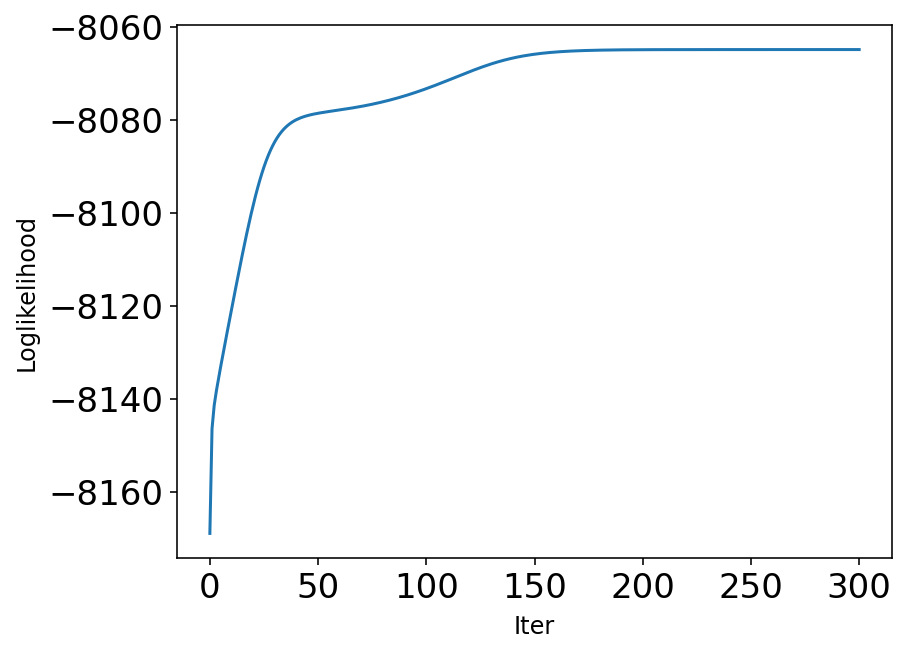

In [20]:
# Model the proposal distribution using MPPCA
M, q = theta_train_std.shape[1], theta_train_std.shape[1]-1
mppca_model_annrs = MPPCA_density_estimate_David(theta_train_std[:,:1],
                                                 theta_train_std[:,1:], 
                                                 M, q, niter=300)

Input Monte Carlo data misfit (L1) as training data samples

In [21]:
mae_misft = (abs(gravity_data-dobs_nsy_survey)).mean(axis=1)

Train ANN surrogate

In [23]:
# input of model paramter theta
theta_input = np.copy(theta_train_std)
# input of misfit 
misfit_input = np.copy(mae_misft.reshape(-1,1))
mistfit_weights = 1/(misfit_input)
prior_min_mis = np.min(mae_misft,axis =0)
prior_max_mis = np.max(mae_misft,axis =0)

# loss function
loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')


# Train the ANN model
S_f_log, S_theta_log, pred_train_log, \
y_train_log, pred_test_log,y_test_log,history_log = ML_dimension_reduction_v4(theta_input,
                                                                              misfit_input,
                                                                              prior_min_mis,
                                                                              prior_max_mis,
                                                                              loss_fn,
                                                                              mistfit_weights=mistfit_weights, 
                                                                              l1_reg = 1e-7, 
                                                                              l2_reg = 1e-6, 
                                                                              learning_rate =2e-3, 
                                                                              num_input = theta_input.shape[1],
                                                                              num_epoch = 1000,
                                                                              batch_size = 200,
                                                                              rand=10, nlayer=10,
                                                                              tf_rand=2)

0epoch [00:00, ?epoch/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (200, 3)                  12        
                                                                 
 dense_1 (Dense)             (200, 3)                  12        
                                                                 
 dense_2 (Dense)             (200, 3)                  12        
                                                                 
 dense_3 (Dense)             (200, 3)                  12        
                                                                 
 dense_4 (Dense)             (200, 3)                  12        
                                                                 
 dense_5 (Dense)             (200, 3)                  12        
                                                                 
 dense_6 (Dense)             (200, 3)                  1

Plot the train model prediction quality

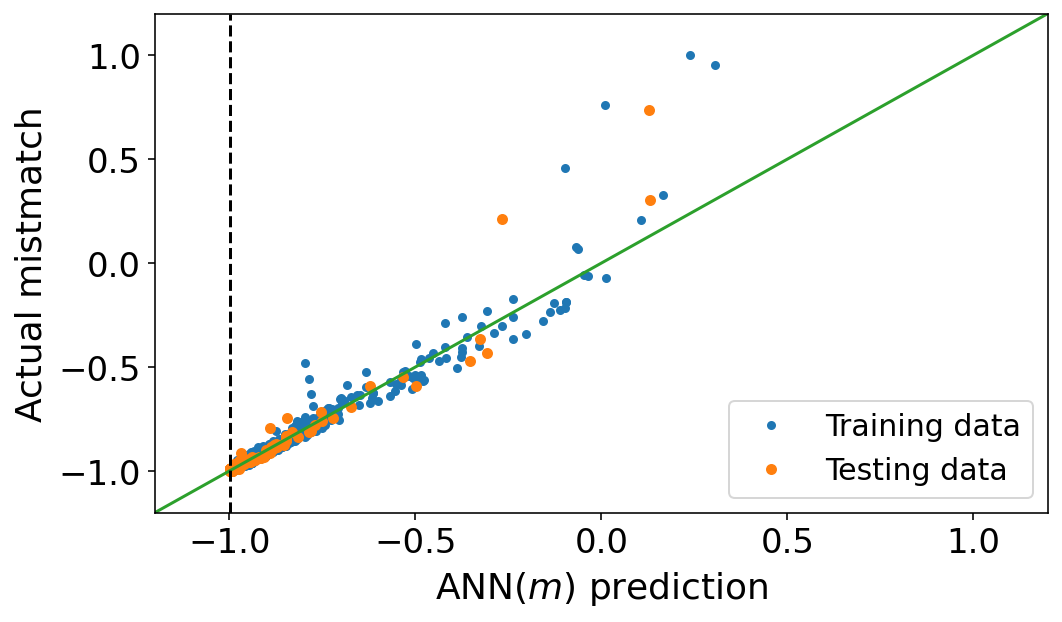

In [24]:
quantile = 0.05
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=[8,4.5])
ax = plt.subplot(1, 1, 1)
ax.vlines(x = np.quantile(pred_train_log[:,0],quantile),
          ymin = -1.2, ymax = 1.2, linestyles='--',color = 'black',zorder = 100)
ax.plot(pred_train_log[:,0], y_train_log[:,0],'.',label = 'Training data', markersize=7)
ax.plot(pred_test_log[:,0], y_test_log[:,0],'.',label = 'Testing data', markersize=9)
ax.plot([-1.2,1.2],[-1.2,1.2])

ax.set_xlabel('ANN($m$) prediction')
ax.set_ylabel('Actual mistmatch')
ax.legend(loc='lower right', prop={'size': 15})
plt.ylim(-1.2,1.2), plt.xlim(-1.2,1.2)
plt.show()

#### Sample posterior with ABC

Determine the epsilon of ABC

In [26]:
esp_percentile = 0.10 # 10th percentile of the training samples
eps = np.quantile(misfit_input[:,0],esp_percentile)

Sampling with random seeds

In [27]:
batch = 100000
# random sample model parameter theta from the density model, a large batch
pos_smpls_rsstd = mppca_model_annrs.mppca_rvs(batch, rand_seed=None)
# estimate misfit using ANN surrogate
misfit_pred = S_f_log.predict(pos_smpls_rsstd)
misfit_pred_back = (misfit_pred+1)/2*(prior_max_mis-prior_min_mis)+prior_min_mis
# Run ABC
pos_smpls_rsstd = pos_smpls_rsstd[misfit_pred_back[:,0]<eps]
# back transform the standardized posterior theta to original space
theta_pos_smpls = pos_smpls_rsstd*theta_train.std(axis=0) + theta_train.mean(axis=0)
# apply the max and min bounds
phys_low_bounds = np.all(theta_pos_smpls>prior_min_logrho, axis=1)
phys_up_bounds = np.all(theta_pos_smpls<prior_max_logrho, axis=1)
theta_pos_smpls = theta_pos_smpls[phys_low_bounds & phys_up_bounds]
# convert final posterior to dataframe
ann_rs_pos = pd.DataFrame(data = np.copy(theta_pos_smpls[:n_Samples]), columns = par_names)
print(len(ann_rs_pos))

3125/3125 [==============================] - 3s 1ms/step
2000


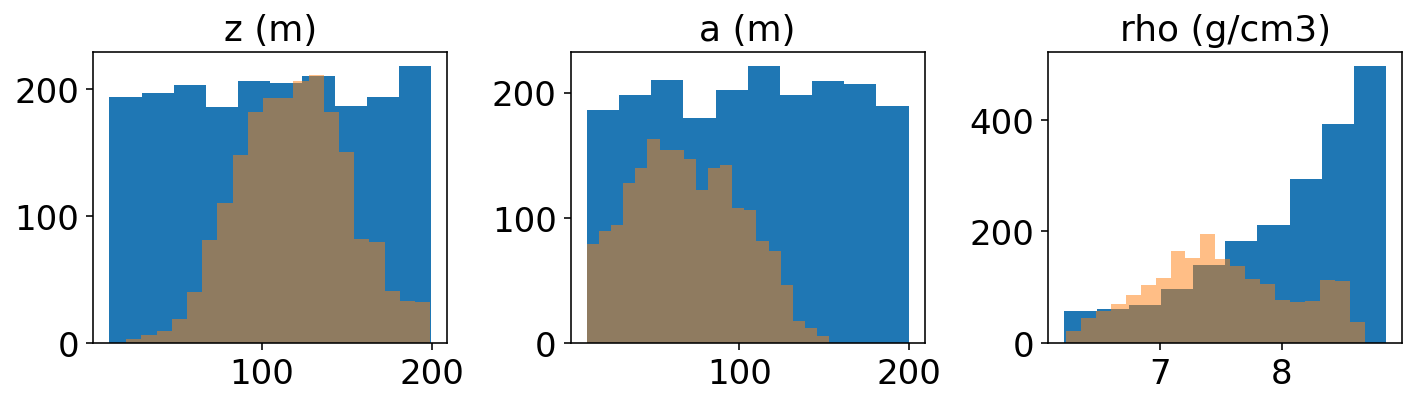

In [28]:
plt.figure(figsize=(10,3))
for i in range(3):
    plt.subplot(1, 3, i+1)
#     plt.hisz_a_rhoa_rho[:,i])
    plt.hist(z_a_rho_logrho[:,i])
    plt.hist(ann_rs_pos.values[:,i], alpha=0.5, bins=20)
    plt.title(par_names[i])
plt.tight_layout()

#### forward model posterior data

In [29]:
ann_rs_pos_val =ann_rs_pos.values

In [30]:
gravity_annrs = []
for i in range(ann_rs_pos_val.shape[0]):
    gravity_annrs.append(g_z_mGal(ann_rs_pos_val[i, 0], ann_rs_pos_val[i, 1], 
                                   np.exp(ann_rs_pos_val[i, 2]), x, c=0))
gravity_annrs = np.asarray(gravity_annrs)

Plot the posterior data

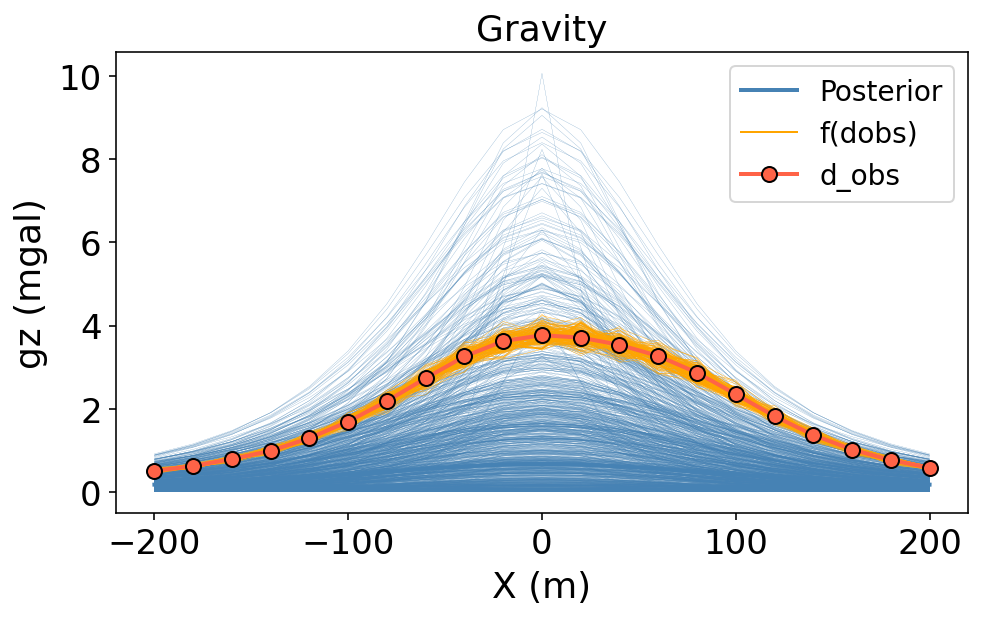

In [31]:
plt.figure(figsize=(7,4.5))
for i in range(0,2000,2):
    plt.plot(x, gravity_annrs[i], '-',  linewidth=0.1, color='steelblue')
plt.plot(x, gravity_annrs[0], '-', linewidth=2, label='Posterior', color='steelblue')
for i in range(0, n_Samples, 15):
    plt.plot(x, dobs_nsy[i], '-', c='orange', linewidth=0.2)
plt.plot(x, dobs_nsy[2], '-',  linewidth=1, color='orange', label='f(dobs)')

plt.plot(x, dobs[0], '.-', label='d_obs',color='tomato',  markeredgecolor='k', linewidth=2, markersize=15)

plt.ylabel('gz (mgal)'), plt.xlabel('X (m)')
plt.legend(prop={'size':14}, loc='upper right')
plt.title('Gravity')
plt.tight_layout()

### 2nd sequence ANN-ABC iteration 
#### Train ANN surrogate

Input Monte Carlo model paramters as training model samples

In [32]:
# select the model parameter, termed theta
theta_train=  ann_rs_pos.values.copy()
theta_train_std = (theta_train-theta_train.mean(axis=0))/theta_train.std(axis=0) # standardize the model parameter

/Users/yinzhen/opt/anaconda3/envs/dave_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


mixture weights: pi =  [0.30698949 0.55031876 0.14269176]
Log likelihood =  -7841.763116765267


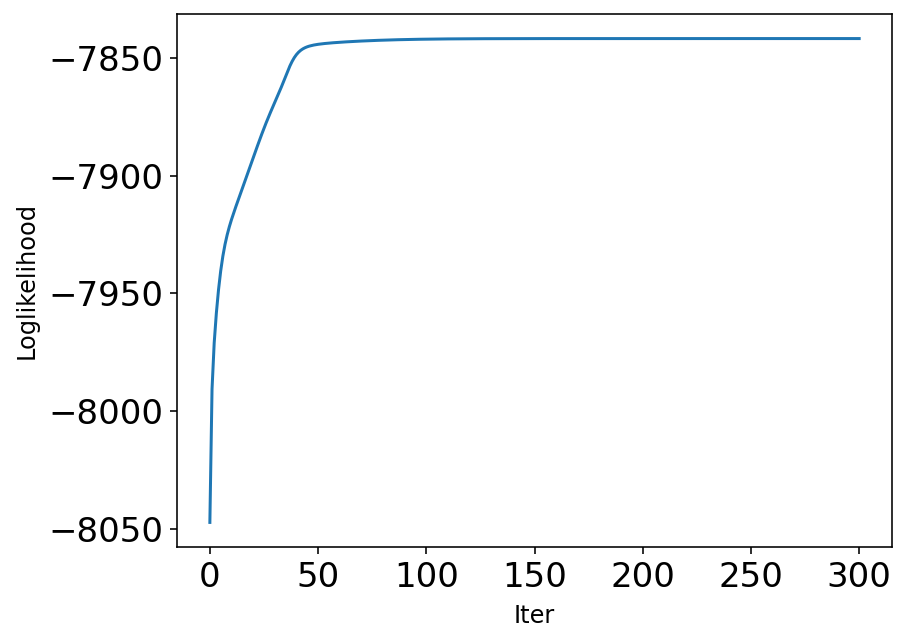

In [33]:
# Model the proposal distribution using MPPCA
M, q = theta_train_std.shape[1], theta_train_std.shape[1]-1
mppca_model_annrs = MPPCA_density_estimate_David(theta_train_std[:,:1],
                                                 theta_train_std[:,1:], 
                                                 M, q, niter=300)

Input Monte Carlo data misfit (L1) as training data samples

In [34]:
mae_misft = (abs(gravity_annrs-dobs_nsy_survey)).mean(axis=1)

Train ANN surrogate

In [35]:
# input of model paramter theta
theta_input = np.copy(theta_train_std)
# input of misfit 
misfit_input = np.copy(mae_misft.reshape(-1,1))
mistfit_weights = 1/(misfit_input**2)
prior_min_mis = np.min(mae_misft,axis =0)
prior_max_mis = np.max(mae_misft,axis =0)

# loss function
loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')


# Train the ANN model
S_f_log, S_theta_log, pred_train_log, \
y_train_log, pred_test_log,y_test_log,history_log = ML_dimension_reduction_v4(theta_input,
                                                                              misfit_input,
                                                                              prior_min_mis,
                                                                              prior_max_mis,
                                                                              loss_fn,
                                                                              mistfit_weights=mistfit_weights, 
                                                                              l1_reg = 1e-6, 
                                                                              l2_reg = 1e-5, 
                                                                              learning_rate =2e-3, 
                                                                              num_input = theta_input.shape[1],
                                                                              num_epoch = 1000,
                                                                              batch_size = 200,
                                                                              rand=10, nlayer=8,
                                                                              tf_rand=2)

0epoch [00:00, ?epoch/s]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (200, 3)                  12        
                                                                 
 dense_12 (Dense)            (200, 3)                  12        
                                                                 
 dense_13 (Dense)            (200, 3)                  12        
                                                                 
 dense_14 (Dense)            (200, 3)                  12        
                                                                 
 dense_15 (Dense)            (200, 3)                  12        
                                                                 
 dense_16 (Dense)            (200, 3)                  12        
                                                                 
 dense_17 (Dense)            (200, 3)                 

Plot the train model prediction quality

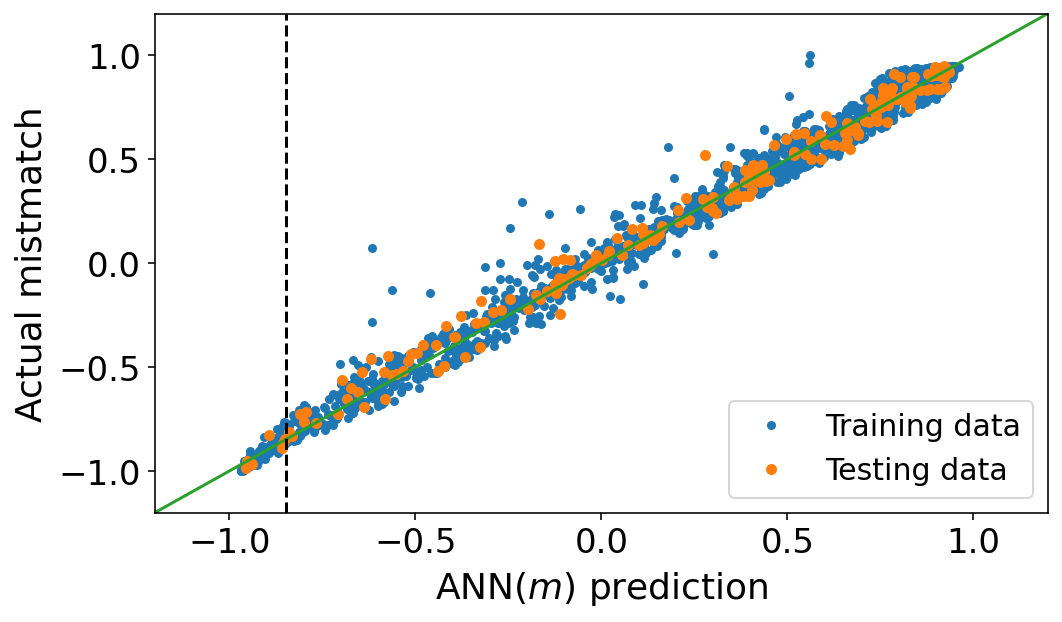

In [36]:
quantile = 0.05
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=[8,4.5])
ax = plt.subplot(1, 1, 1)
ax.vlines(x = np.quantile(pred_train_log[:,0],quantile),
          ymin = -1.2, ymax = 1.2, linestyles='--',color = 'black',zorder = 100)
ax.plot(pred_train_log[:,0], y_train_log[:,0],'.',label = 'Training data', markersize=7)
ax.plot(pred_test_log[:,0], y_test_log[:,0],'.',label = 'Testing data', markersize=9)
ax.plot([-1.2,1.2],[-1.2,1.2])

ax.set_xlabel('ANN($m$) prediction')
ax.set_ylabel('Actual mistmatch')
ax.legend(loc='lower right', prop={'size': 15})
plt.ylim(-1.2,1.2), plt.xlim(-1.2,1.2)
plt.show()

#### Sample posterior with ABC

Determine the epsilon of ABC

In [37]:
esp_percentile = 0.025# 2.5th percentile of the training samples
eps = np.quantile(misfit_input[:,0],esp_percentile)

Sampling with random seeds

In [38]:
batch = 200000
# random sample model parameter theta from the density model, a large batch
pos_smpls_rsstd = mppca_model_annrs.mppca_rvs(batch, rand_seed=None)
# estimate misfit using ANN surrogate
misfit_pred = S_f_log.predict(pos_smpls_rsstd)
misfit_pred_back = (misfit_pred+1)/2*(prior_max_mis-prior_min_mis)+prior_min_mis
# Run ABC
pos_smpls_rsstd = pos_smpls_rsstd[misfit_pred_back[:,0]<eps]
# back transform the standardized posterior theta to original space
theta_pos_smpls = pos_smpls_rsstd*theta_train.std(axis=0) + theta_train.mean(axis=0)
# apply the max and min bounds
phys_low_bounds = np.all(theta_pos_smpls>prior_min_logrho, axis=1)
phys_up_bounds = np.all(theta_pos_smpls<prior_max_logrho, axis=1)
theta_pos_smpls = theta_pos_smpls[phys_low_bounds & phys_up_bounds]
# convert final posterior to dataframe
ann_rs_pos = pd.DataFrame(data = np.copy(theta_pos_smpls[:n_Samples]), columns = par_names)
print(len(ann_rs_pos))

6250/6250 [==============================] - 7s 1ms/step
2000


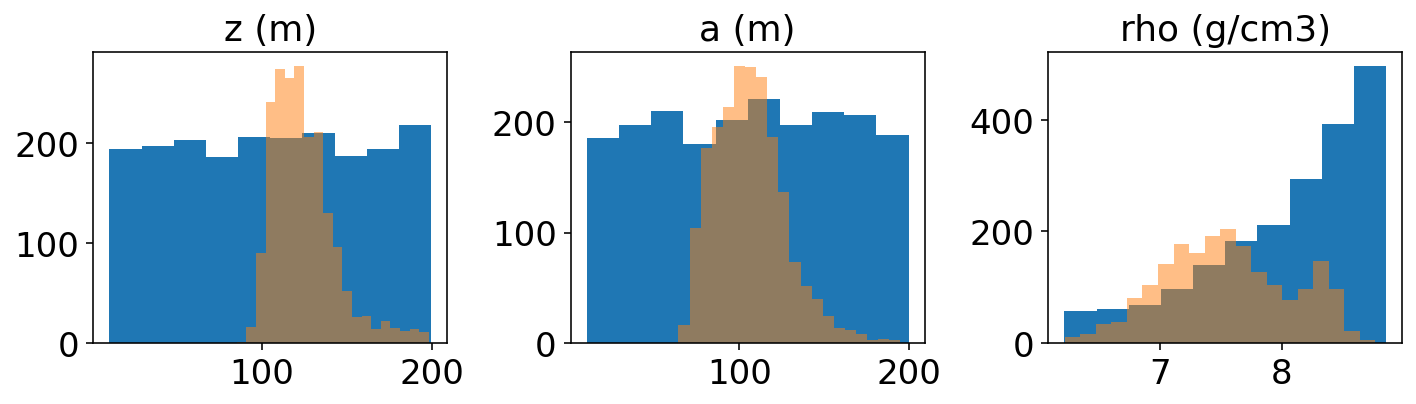

In [39]:
plt.figure(figsize=(10,3))
for i in range(3):
    plt.subplot(1, 3, i+1)
#     plt.hisz_a_rhoa_rho[:,i])
    plt.hist(z_a_rho_logrho[:,i])
    plt.hist(ann_rs_pos.values[:,i], alpha=0.5, bins=20)
    plt.title(par_names[i])
plt.tight_layout()

#### forward model posterior data

In [40]:
ann_rs_pos_val =ann_rs_pos.values

In [41]:
gravity_annrs = []
for i in range(ann_rs_pos_val.shape[0]):
    gravity_annrs.append(g_z_mGal(ann_rs_pos_val[i, 0], ann_rs_pos_val[i, 1], 
                                   np.exp(ann_rs_pos_val[i, 2]), x, c=0))
gravity_annrs = np.asarray(gravity_annrs)

Plot the posterior data

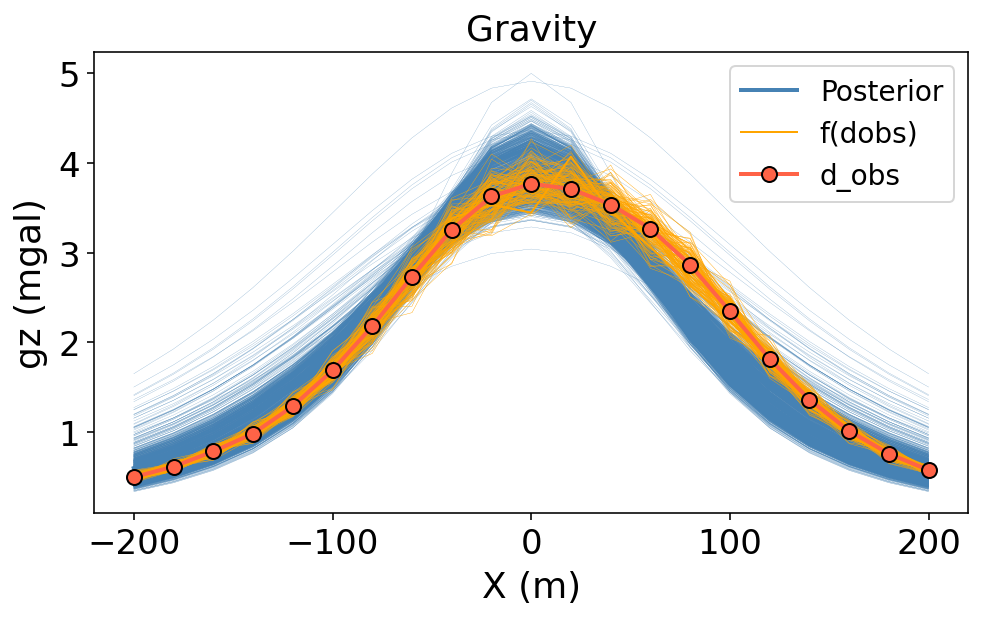

In [42]:
plt.figure(figsize=(7,4.5))
for i in range(0,2000,2):
    plt.plot(x, gravity_annrs[i], '-',  linewidth=0.1, color='steelblue')
plt.plot(x, gravity_annrs[0], '-', linewidth=2, label='Posterior', color='steelblue')
for i in range(0, n_Samples, 15):
    plt.plot(x, dobs_nsy[i], '-', c='orange', linewidth=0.2)
plt.plot(x, dobs_nsy[2], '-',  linewidth=1, color='orange', label='f(dobs)')

plt.plot(x, dobs[0], '.-', label='d_obs',color='tomato',  markeredgecolor='k', linewidth=2, markersize=15)

plt.ylabel('gz (mgal)'), plt.xlabel('X (m)')
plt.legend(prop={'size':14}, loc='upper right')
plt.title('Gravity')
plt.tight_layout()

### 3rd sequence ANN-ABC iteration 
#### Train ANN surrogate

Input Monte Carlo model paramters as training model samples

In [43]:
# select the model parameter, termed theta
theta_train=  ann_rs_pos.values.copy()
theta_train_std = (theta_train-theta_train.mean(axis=0))/theta_train.std(axis=0) # standardize the model parameter

/Users/yinzhen/opt/anaconda3/envs/dave_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


mixture weights: pi =  [0.63444152 0.30394772 0.06161076]
Log likelihood =  -3095.9114666144214


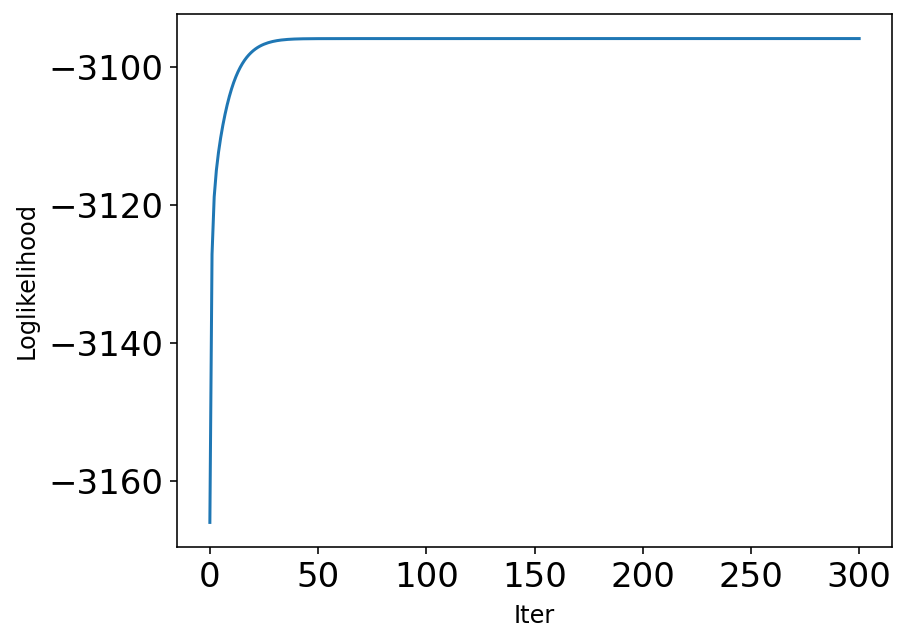

In [44]:
# Model the proposal distribution using MPPCA
M, q = theta_train_std.shape[1], theta_train_std.shape[1]-1
mppca_model_annrs = MPPCA_density_estimate_David(theta_train_std[:,:1],
                                                 theta_train_std[:,1:], 
                                                 M, q, niter=300)

Input Monte Carlo data misfit (L1) as training data samples

In [45]:
mae_misft = (abs(gravity_annrs-dobs_nsy_survey)).mean(axis=1)

Train ANN surrogate

In [62]:
# input of model paramter theta
theta_input = np.copy(theta_train_std)
# input of misfit 
misfit_input = np.copy(mae_misft.reshape(-1,1))
mistfit_weights = 1/(misfit_input**3)
prior_min_mis = np.min(mae_misft,axis =0)
prior_max_mis = np.max(mae_misft,axis =0)

# loss function
loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')


# Train the ANN model
S_f_log, S_theta_log, pred_train_log, \
y_train_log, pred_test_log,y_test_log,history_log = ML_dimension_reduction_v4(theta_input,
                                                                              misfit_input,
                                                                              prior_min_mis,
                                                                              prior_max_mis,
                                                                              loss_fn,
                                                                              mistfit_weights=mistfit_weights, 
                                                                              l1_reg = 1e-7, # 2e-4 theta_std
                                                                              l2_reg = 1e-6, # 2e-3 theta_std
                                                                              learning_rate =2e-3, 
                                                                              num_input = theta_input.shape[1],
                                                                              num_epoch = 1000,
                                                                              batch_size = 200,
                                                                              rand=10, nlayer=15,
                                                                              tf_rand=2)

0epoch [00:00, ?epoch/s]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (200, 3)                  12        
                                                                 
 dense_43 (Dense)            (200, 3)                  12        
                                                                 
 dense_44 (Dense)            (200, 3)                  12        
                                                                 
 dense_45 (Dense)            (200, 3)                  12        
                                                                 
 dense_46 (Dense)            (200, 3)                  12        
                                                                 
 dense_47 (Dense)            (200, 3)                  12        
                                                                 
 dense_48 (Dense)            (200, 3)                 

Plot the train model prediction quality

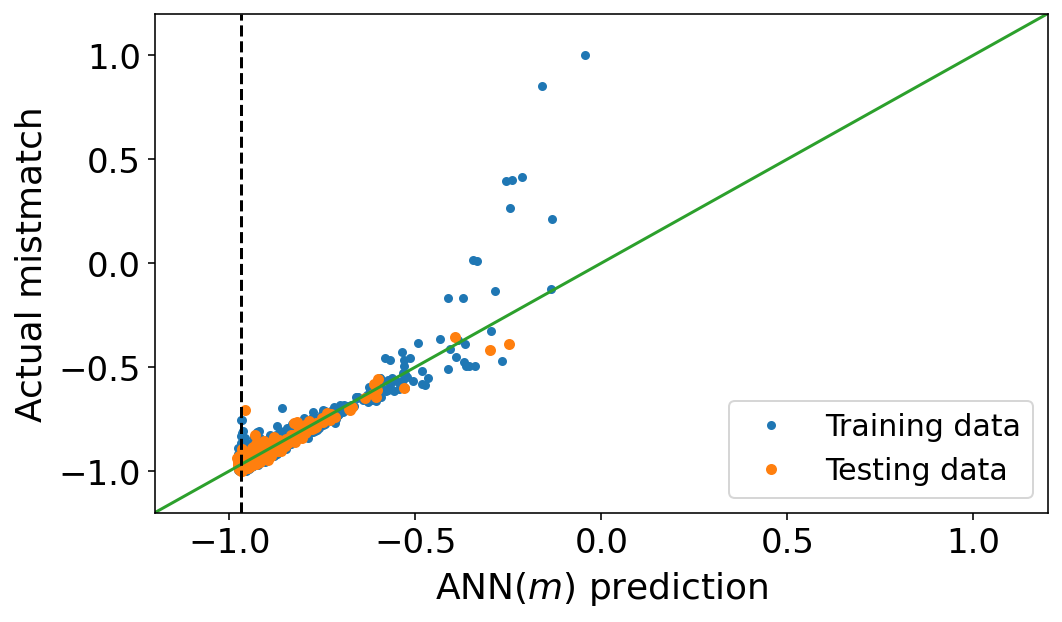

In [63]:
quantile = 0.10
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=[8,4.5])
ax = plt.subplot(1, 1, 1)
ax.vlines(x = np.quantile(pred_train_log[:,0],quantile),
          ymin = -1.2, ymax = 1.2, linestyles='--',color = 'black',zorder = 100)
ax.plot(pred_train_log[:,0], y_train_log[:,0],'.',label = 'Training data', markersize=7)
ax.plot(pred_test_log[:,0], y_test_log[:,0],'.',label = 'Testing data', markersize=9)
ax.plot([-1.2,1.2],[-1.2,1.2])

ax.set_xlabel('ANN($m$) prediction')
ax.set_ylabel('Actual mistmatch')
ax.legend(loc='lower right', prop={'size': 15})
plt.ylim(-1.2,1.2), plt.xlim(-1.2,1.2)
plt.show()

#### Sample posterior with ABC

Determine the epsilon of ABC

In [66]:
esp_percentile = 0.1
eps = np.quantile(misfit_input[:,0],esp_percentile)

Sampling with random seeds

In [67]:
batch = 200000
# random sample model parameter theta from the density model, a large batch
pos_smpls_rsstd = mppca_model_annrs.mppca_rvs(batch, rand_seed=None)
# estimate misfit using ANN surrogate
misfit_pred = S_f_log.predict(pos_smpls_rsstd)
misfit_pred_back = (misfit_pred+1)/2*(prior_max_mis-prior_min_mis)+prior_min_mis
# Run ABC
pos_smpls_rsstd = pos_smpls_rsstd[misfit_pred_back[:,0]<eps]
# back transform the standardized posterior theta to original space
theta_pos_smpls = pos_smpls_rsstd*theta_train.std(axis=0) + theta_train.mean(axis=0)
# apply the max and min bounds
phys_low_bounds = np.all(theta_pos_smpls>prior_min_logrho, axis=1)
phys_up_bounds = np.all(theta_pos_smpls<prior_max_logrho, axis=1)
theta_pos_smpls = theta_pos_smpls[phys_low_bounds & phys_up_bounds]
# convert final posterior to dataframe
ann_rs_pos = pd.DataFrame(data = np.copy(theta_pos_smpls[:n_Samples]), columns = par_names)
print(len(ann_rs_pos))

6250/6250 [==============================] - 7s 1ms/step
2000


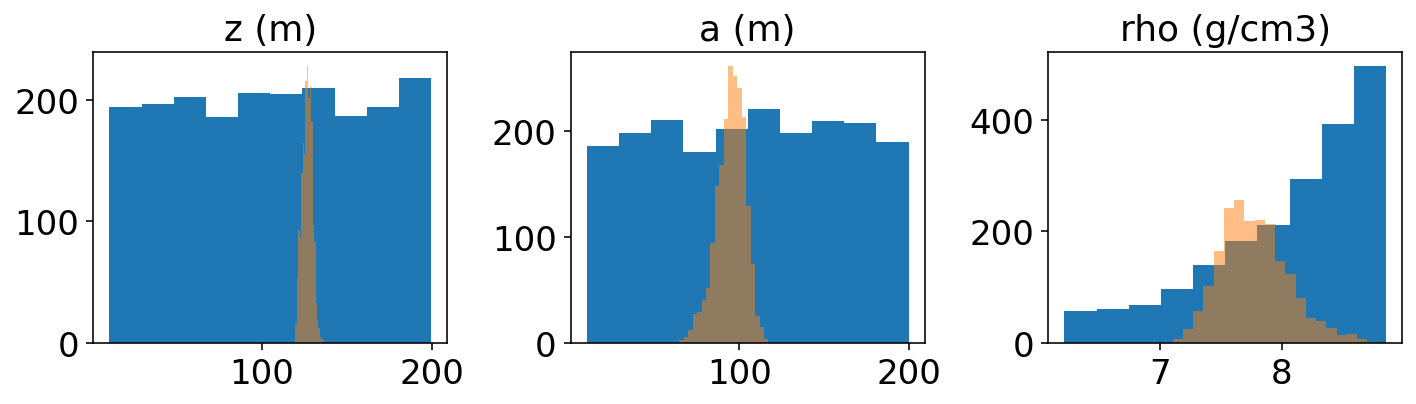

In [68]:
plt.figure(figsize=(10,3))
for i in range(3):
    plt.subplot(1, 3, i+1)
#     plt.hisz_a_rhoa_rho[:,i])
    plt.hist(z_a_rho_logrho[:,i])
    plt.hist(ann_rs_pos.values[:,i], alpha=0.5, bins=20)
    plt.title(par_names[i])
plt.tight_layout()

#### forward model posterior data

In [69]:
ann_rs_pos_val =ann_rs_pos.values

In [70]:
gravity_annrs = []
for i in range(ann_rs_pos_val.shape[0]):
    gravity_annrs.append(g_z_mGal(ann_rs_pos_val[i, 0], ann_rs_pos_val[i, 1], 
                                   np.exp(ann_rs_pos_val[i, 2]), x, c=0))
gravity_annrs = np.asarray(gravity_annrs)

Plot the posterior data

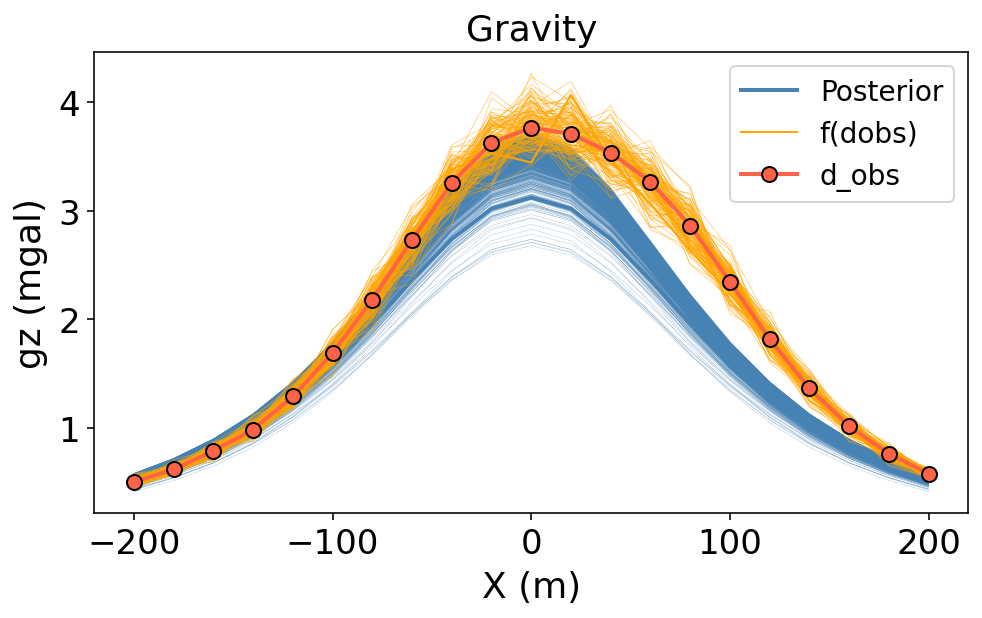

In [71]:
plt.figure(figsize=(7,4.5))
for i in range(0,2000,2):
    plt.plot(x, gravity_annrs[i], '-',  linewidth=0.1, color='steelblue')
plt.plot(x, gravity_annrs[0], '-', linewidth=2, label='Posterior', color='steelblue')
for i in range(0, n_Samples, 15):
    plt.plot(x, dobs_nsy[i], '-', c='orange', linewidth=0.2)
plt.plot(x, dobs_nsy[2], '-',  linewidth=1, color='orange', label='f(dobs)')

plt.plot(x, dobs[0], '.-', label='d_obs',color='tomato',  markeredgecolor='k', linewidth=2, markersize=15)

plt.ylabel('gz (mgal)'), plt.xlabel('X (m)')
plt.legend(prop={'size':14}, loc='upper right')
plt.title('Gravity')
plt.tight_layout()

Plot posterior model paramters

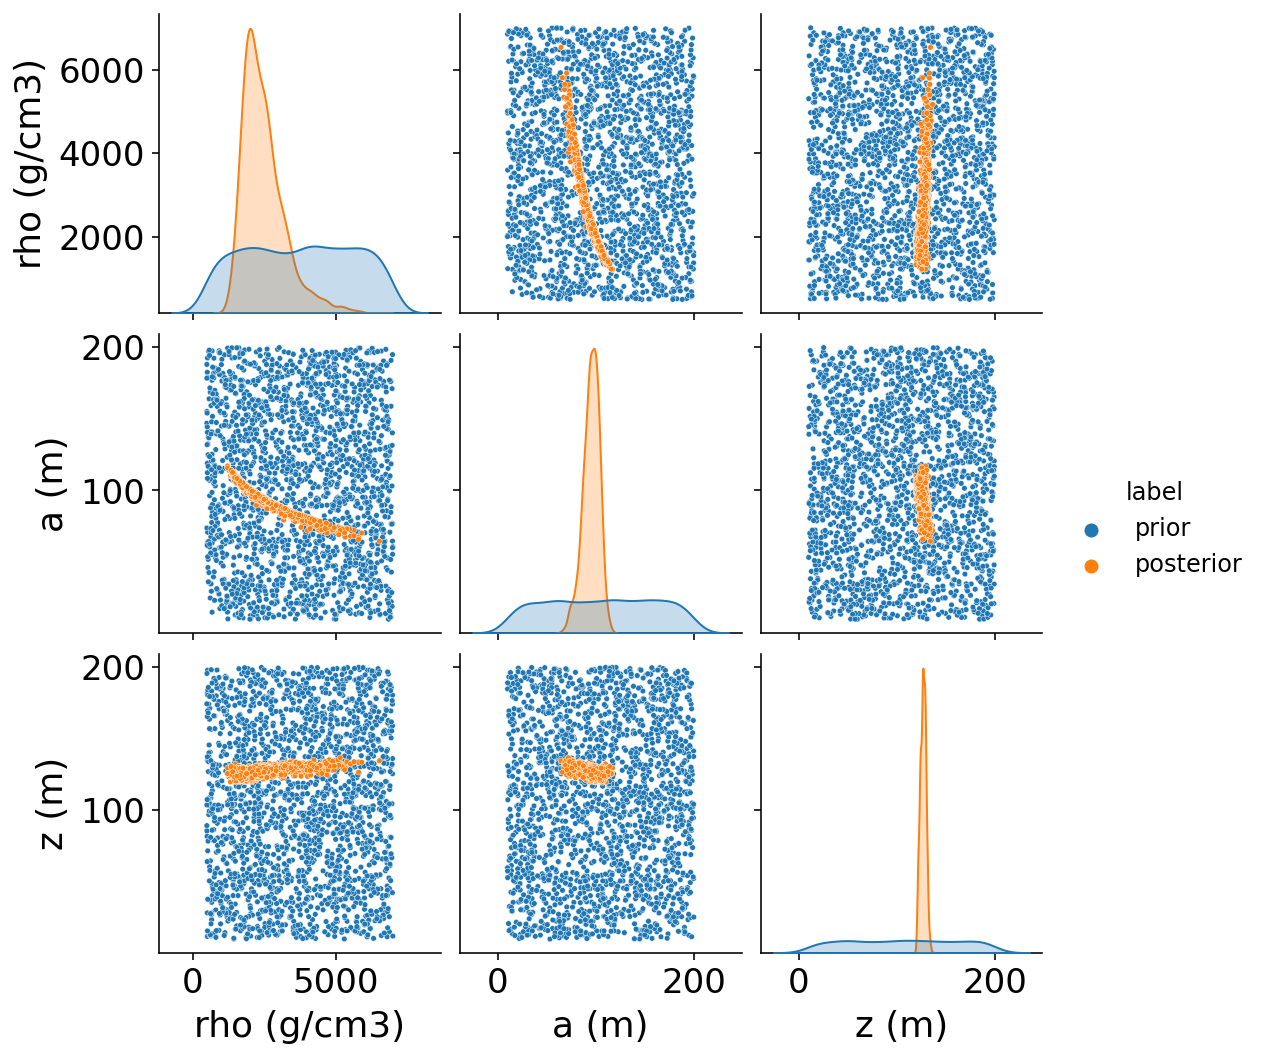

In [72]:
ann_rs_pos['label'] = 'posterior'
ann_rs_pos['rho (g/cm3)'] = np.exp(ann_rs_pos['rho (g/cm3)'])
theta_pos_0err =prior_theta.copy()
theta_pos_0err['label'] = 'prior'

pltdata =  pd.concat([theta_pos_0err, ann_rs_pos,], ignore_index=True)

pairnames = par_names[:3]
sns.pairplot(
    pltdata,
    y_vars=pairnames[::-1],
    x_vars=pairnames[::-1],
    plot_kws={"s": 8}, 
    hue='label'
    #     kind="reg"
)

## Plot the SMC posterior conductor


In [73]:
pltquantiles = np.arange(0.25,0.75,0.05)

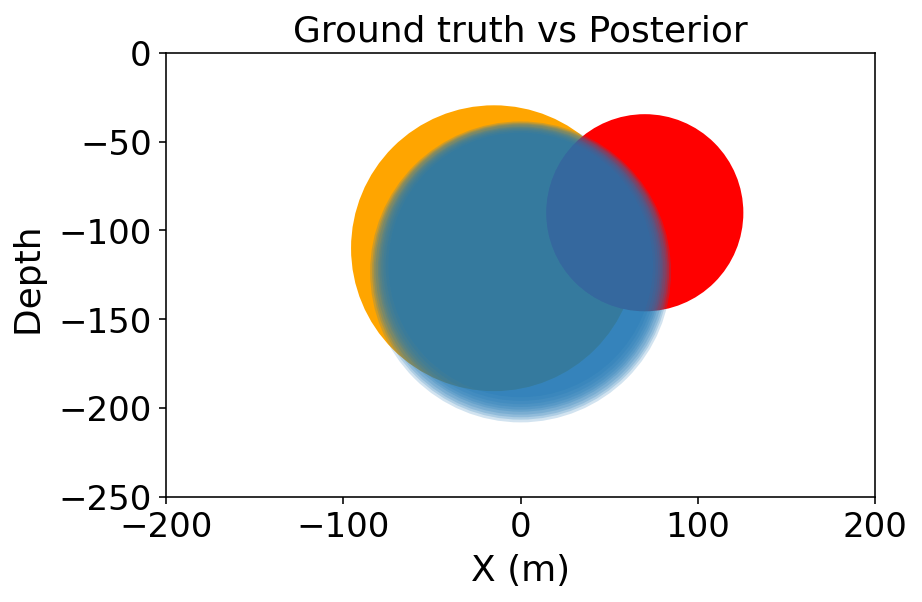

In [74]:
figure, axes = plt.subplots(figsize=(8,4))


Drawing_colored_circle1 = plt.Circle((x1, -m_obs1[0] ), m_obs1[1], color='orange',
                                    label='C1')
axes.add_artist( Drawing_colored_circle1 )

Drawing_colored_circle2 = plt.Circle((x2 , -m_obs2[0] ),  m_obs2[1], color='red',
                                    label='C2')
axes.add_artist( Drawing_colored_circle2 )
for i in pltquantiles:
    Drawing_colored_circle = plt.Circle((0, -np.quantile(ann_rs_pos['z (m)'].values,i)+5), 
                                    np.quantile(ann_rs_pos['a (m)'].values,i)-15, 
                                     alpha=0.20
                                   )
    axes.add_artist( Drawing_colored_circle )
axes.set_aspect( 1 )
plt.ylim(0,-250), plt.xlim(-200,200)
plt.gca().invert_yaxis()
# plt.legend()
plt.ylabel('Depth '), plt.xlabel('X (m)')
plt.title( 'Ground truth vs Posterior' )
plt.show()

  0%|          | 0/21 [00:00<?, ?it/s]

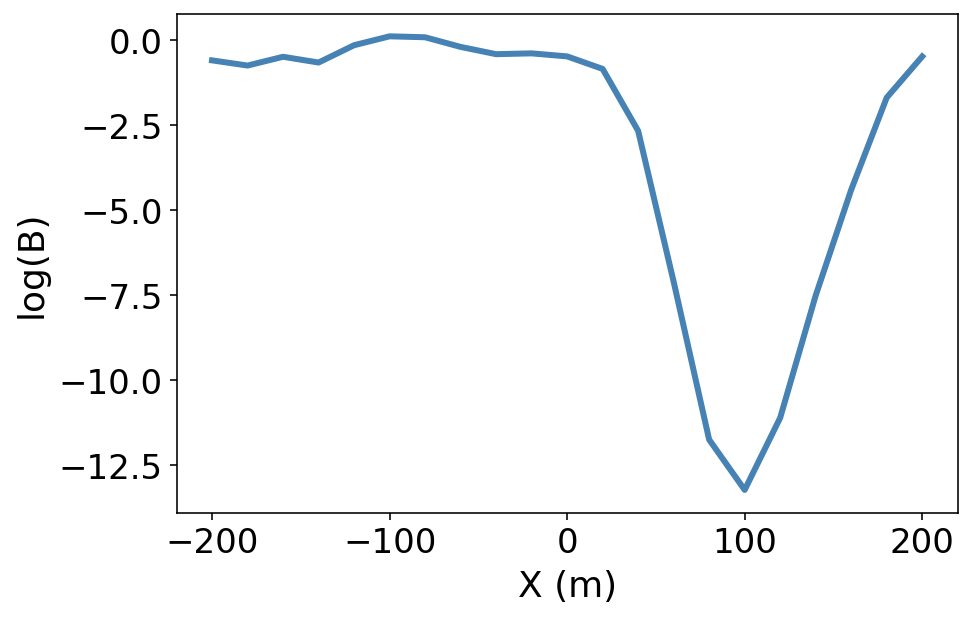

In [77]:
Bayes_Fctrs = []
for loc_x in tqdm(range(gravity_annrs.shape[1])):
    d_pos_i = gravity_annrs[:,loc_x]
    d_fobs_i = dobs_nsy[:,loc_x]
    Bayes_Fctrs.append(ModelError_BayesF(d_pos_i, d_fobs_i))
Bayes_Fctrs = np.asarray(Bayes_Fctrs)
plt.figure(figsize=(7,4.5))
plt.plot(x, np.log(Bayes_Fctrs), '-', color='steelblue', linewidth=3)
plt.ylabel('log(B)'), plt.xlabel('X (m)')
# plt.title( 'Bayes factor' )
plt.show()

* Conclusion: we need more complex geological model representation, at location x=100m. 

* Next: using two sphere model